In [1]:
onedrive = r"C:\Users\mikek\OneDrive"
# %matplotlib ipympl
# %matplotlib qt
# %matplotlib widget
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from gridtools.hypnotoad_tools import *
from gridtools.b2_tools import *
from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from code_comparison.code_comparison import *
import matplotlib as mpl

%load_ext autoreload
%autoreload 2


print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


# IO

In [2]:
toload = {
    "new_curve" : "stc5a-upgrade_ar_curve",
    "hires" : "stc7b-ar2pc"
    
}

cs = dict()   # casestore

for name in toload:
    print(f"Loading {toload[name]}")
    cs[name] = Load.case_1D(os.path.join(onedrive_path, rf"Project\collab\tech\cases\step1d_shocktests\{toload[name]}"))


Loading stc5a-upgrade_ar_curve


c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


Loading stc7b-ar2pc


c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


In [43]:
%matplotlib inline

Text(0.5, 1.0, 'Detachment front')

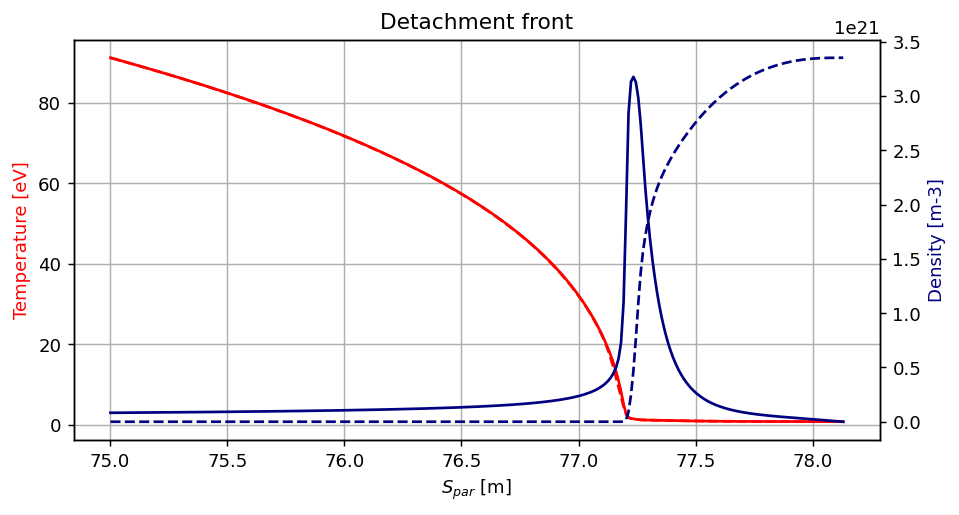

In [48]:
casename = "new_curve"
ds = cs[casename].ds.isel(pos=slice(1,-1), t = -1)
ds = ds.sel(pos=slice(75,None))

fig, ax = plt.subplots(dpi = 130, figsize = (8,4))
# ds["Te"].plot(ax = ax, c = "r", ls = ":", label = "Electron")
ds["Td+"].plot(ax = ax, c = "r", ls = "-", label = "Plasma")
ds["Td"].plot(ax = ax, c = "r", ls = "--", label = "Neutral")

ax2 = ax.twinx()
ds["Ne"].plot(ax = ax2, c = "navy", ls = "-")
ds["Nd"].plot(ax = ax2, c = "navy", ls = "--")

# ax.set_xscale("log")
ax.set_xlabel("$S_{par}$ [m]")
ax.set_ylabel("Temperature [eV]", color = "red")
ax2.set_ylabel("Density [m-3]", color = "navy")
ax.grid()
# ax.legend(loc="center right")
# ax.set_title(caselabels[casename])
ax2.set_title("")
ax.set_title("Detachment front")


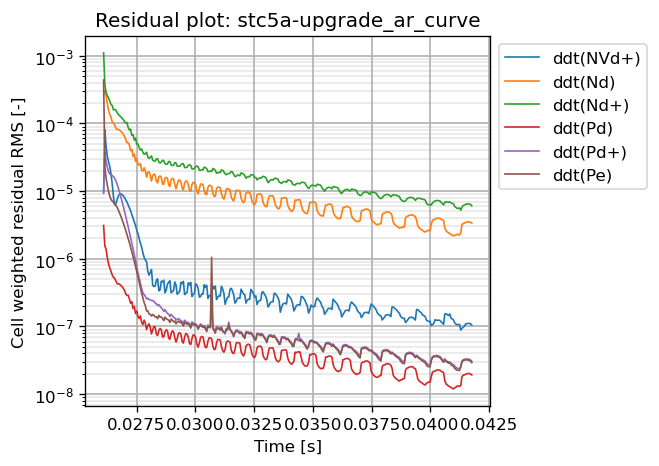

In [3]:
for name in toload:
    plot_ddt(cs[name])

## CVODE diagnostics

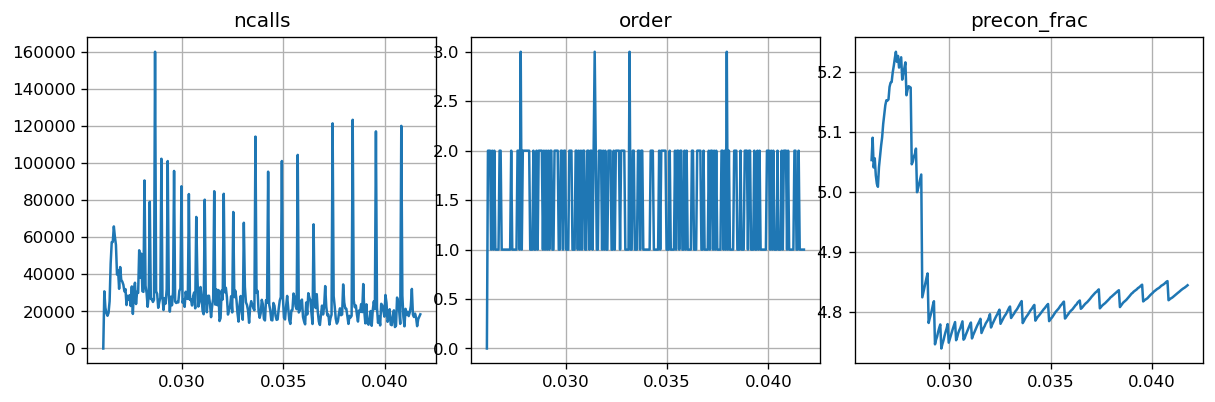

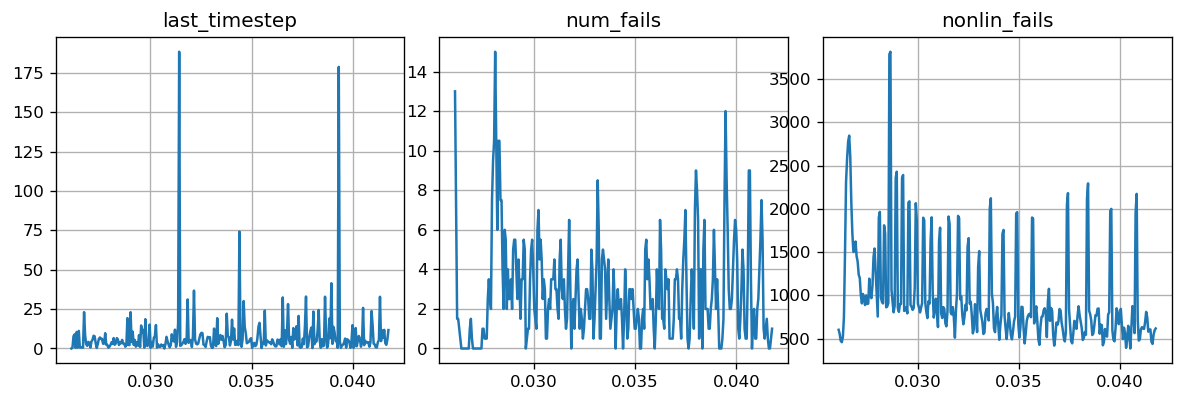

In [8]:
ds = cs["new_curve"].ds
def plot(data):
    num_plots = len(data.keys())

    t = ds.coords["t"]

    fig = plt.figure(dpi=120)
    fig.set_figheight(4)
    fig.set_figwidth(num_plots*4)
    fig.subplots_adjust(bottom = 0.2)

    # Plot grid
    gs = mpl.gridspec.GridSpec(
                                    ncols=num_plots, nrows=1,
                                    wspace = 0.1
                                    )



    axes = [None] * len(data.keys())


    for i, param in enumerate(data.keys()):
        # All plots after the first one share x and y axes
        if i == 0:
            axes[i] = fig.add_subplot(gs[i])
        else:
            axes[i] = fig.add_subplot(gs[i], sharex=axes[0])
            
        axes[i].plot(t, data[param])
        axes[i].set_title(param)
        axes[i].grid()
        
data = dict()
data["ncalls"] = ds["ncalls"].values
data["order"] = ds["cvode_last_order"].values
data["precon_frac"] = np.divide(ds["cvode_npevals"],(ds["cvode_nfevals"]))
# data["stab_lims"] = ds["cvode_stab_lims"]
plot(data)

data = dict()
data["last_timestep"] = ds["cvode_last_step"]
data["num_fails"] = np.clip(np.gradient(ds["cvode_num_fails"]), 0, None)
data["nonlin_fails"] = np.clip(np.gradient(ds["cvode_nonlin_fails"]), 0, None) #np.gradient(t, ds["cvode_nonlin_fails"])
plot(data)


# Capturing spike

In [61]:
%matplotlib inline

Text(0.5, 1.0, 'RHS calls per simulation time')

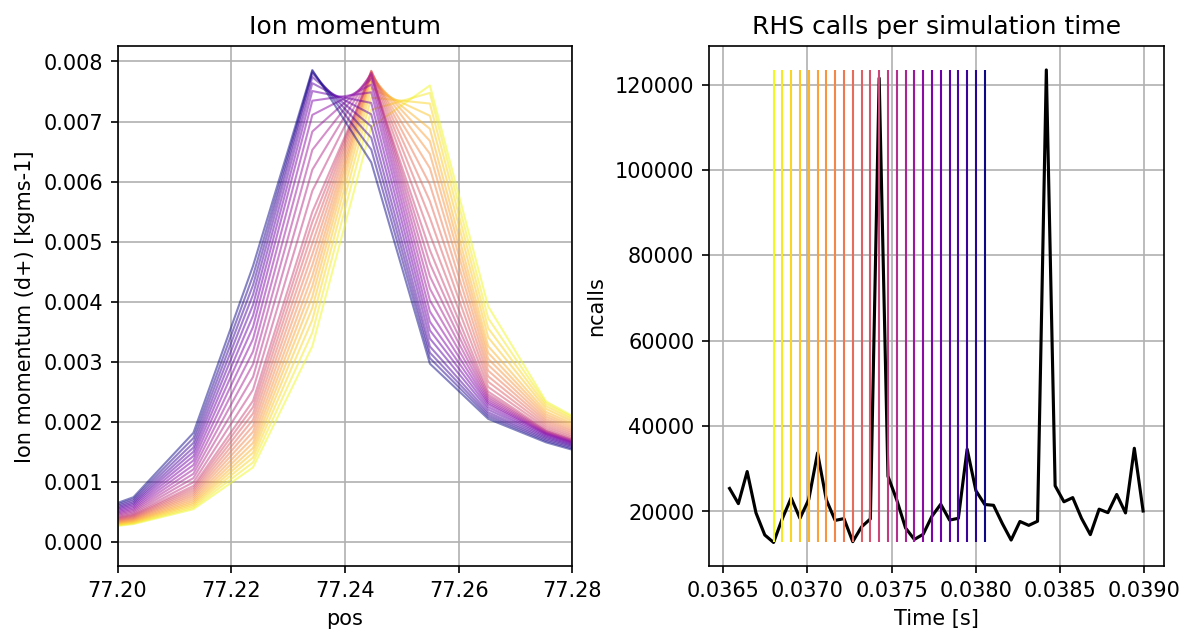

In [66]:
fig, axes = plt.subplots(1, 2, figsize = (9, 4.5), dpi = 150)
fig.subplots_adjust(wspace = 0.3)


ds = cs["new_curve"].ds
ds_spike = ds.sel(t = slice(0.0365, 0.039))

# time_idx = [1,2]
time_idx = np.arange(5, 30, 1)
times = ds_spike["t"].isel(t = time_idx)
colors = make_cmap("plasma", len(times))[::-1]



ax = axes[0]

for i, t in enumerate(time_idx):
    ds_spike["NVd+"].isel(t=t).plot(ax = ax, c = colors[i], alpha = 0.5, lw = 1)
# ax.set_yscale("log")
ax.grid()
ax.set_xlim(77.2, 77.28)
ax.set_title("Ion momentum")
# ax.set_ylim(3.1e8, 3.9e8)
ax = axes[1]

auxdata = ds_spike["ncalls"]
auxdata.plot(ax = ax, c = "k")

ax.vlines(times, auxdata.min(), auxdata.max(), colors = colors, lw = 1)
# ax.set_yscale("log")
ax.grid()
ax.set_title("RHS calls per simulation time")

### Mom gradient

Text(0.5, 1.0, 'RHS calls per simulation time')

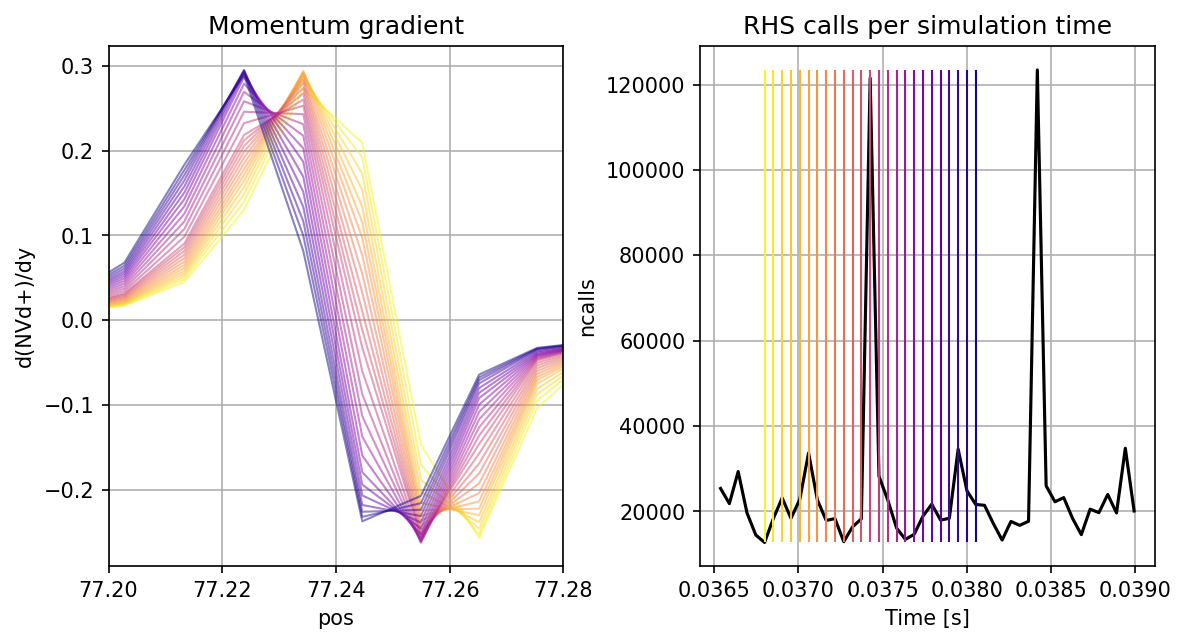

In [65]:
fig, axes = plt.subplots(1, 2, figsize = (9, 4.5), dpi = 150)
fig.subplots_adjust(wspace = 0.3)


ds = cs["new_curve"].ds
ds_spike = ds.sel(t = slice(0.0365, 0.039))

# time_idx = [1,2]
time_idx = np.arange(5, 30, 1)
times = ds_spike["t"].isel(t = time_idx)
colors = make_cmap("plasma", len(times))[::-1]



ax = axes[0]

for i, t in enumerate(time_idx):
    ds_spike["NVd+"].differentiate("pos").isel(t=t).plot(ax = ax, c = colors[i], alpha = 0.5, lw = 1)
# ax.set_yscale("log")
ax.grid()
ax.set_xlim(77.2, 77.28)
ax.set_title("Momentum gradient")
ax.set_ylabel("d(NVd+)/dy")
# ax.set_ylim(3.1e8, 3.9e8)
ax = axes[1]

auxdata = ds_spike["ncalls"]
auxdata.plot(ax = ax, c = "k")

ax.vlines(times, auxdata.min(), auxdata.max(), colors = colors, lw = 1)
# ax.set_yscale("log")
ax.grid()
ax.set_title("RHS calls per simulation time")

In [ ]:
### CVODE stats

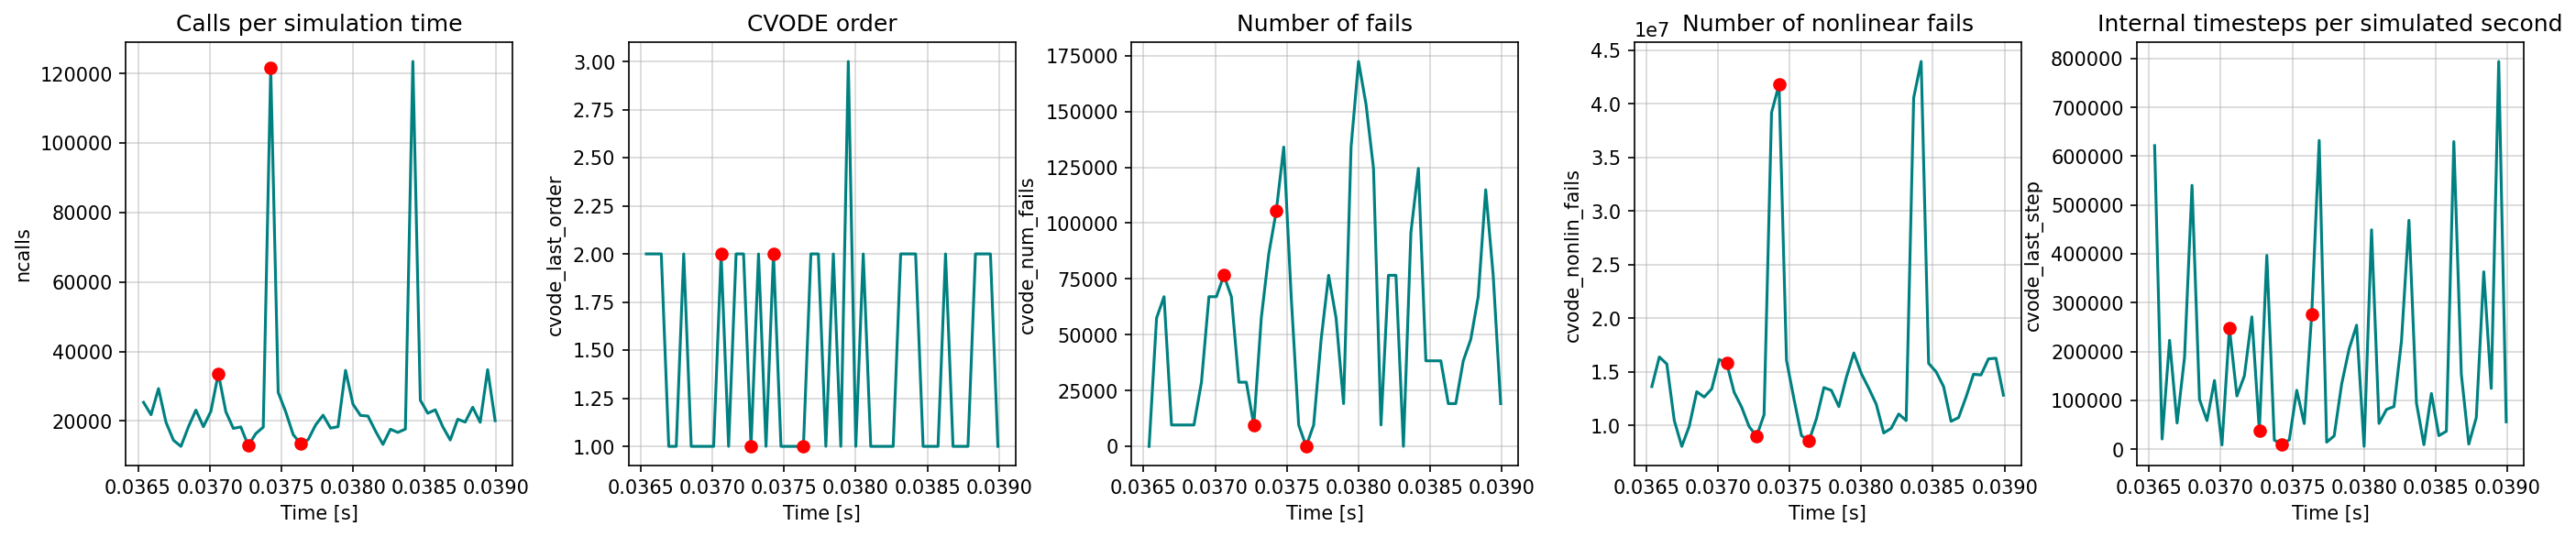

In [109]:

fig, axes = plt.subplots(1, 5, figsize = (4.5*5, 4), dpi = 150)
fig.subplots_adjust(wspace = 0.3)


ds = cs["new_curve"].ds
ds_spike = ds.sel(t = slice(0.0365, 0.039))

time_idx = [10, 14, 17, 21]
# time_idx = np.arange(5, 30, 5)
times = ds_spike["t"].isel(t = time_idx)
colors = make_cmap("plasma", len(times))[::-1]

color = "teal"

ax = axes[0]
ds_spike["ncalls"].plot(ax = ax, c = color)
ds_spike["ncalls"].isel(t=time_idx).plot(ax = ax, c = "red", marker = "o", lw = 0)
ax.set_title("Calls per simulation time")

ax = axes[1]
ds_spike["cvode_last_order"].plot(ax = ax, c = color)
ds_spike["cvode_last_order"].isel(t=time_idx).plot(ax = ax, c = "red", marker = "o", lw = 0)
ax.set_title("CVODE order")

ax = axes[2]
ds_spike["cvode_num_fails"].differentiate("t").plot(ax = ax, c = color)
ds_spike["cvode_num_fails"].differentiate("t").isel(t=time_idx).plot(ax = ax, c = "red", marker = "o", lw = 0)
ax.set_title("Number of fails")

ax = axes[3]
ds_spike["cvode_nonlin_fails"].differentiate("t").plot(ax = ax, c = color)
ds_spike["cvode_nonlin_fails"].differentiate("t").isel(t=time_idx).plot(ax = ax, c = "red", marker = "o", lw = 0)
ax.set_title("Number of nonlinear fails")

ax = axes[4]
(ds_spike["cvode_last_step"] / 5.219842377254119e-05).plot(ax = ax, c = color)
(ds_spike["cvode_last_step"] / 5.219842377254119e-05).isel(t=time_idx).plot(ax = ax, c = "red", marker = "o", lw = 0)
ax.set_title("Internal timesteps per simulated second")

for ax in axes:
    # ax.vlines(times, ax.get_ylim()[0], ax.get_ylim()[1], colors = colors, lw = 2)
# ax.set_yscale("log")
    ax.grid(alpha = 0.5)
# ax.set_title("RHS calls per simulation time")

In [107]:
ds["t"].values[-1] - ds["t"].values[-2]

5.219842377254119e-05

### Walk animation

In [50]:
%matplotlib widget

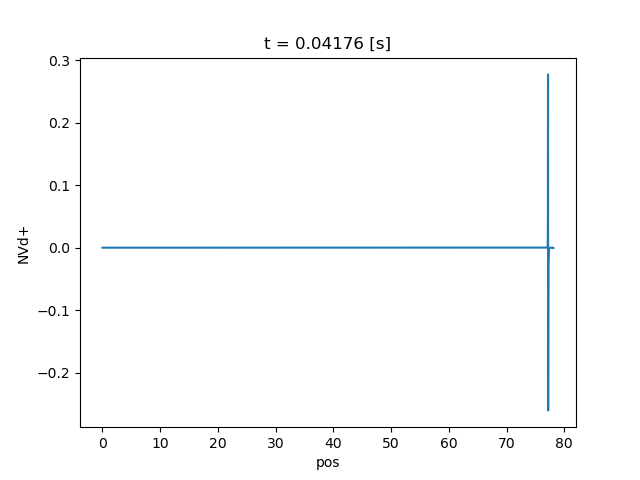

In [22]:
fig, ax = plt.subplots()
ds["NVd+"].differentiate("pos").isel(t=-1).plot(ax = ax)

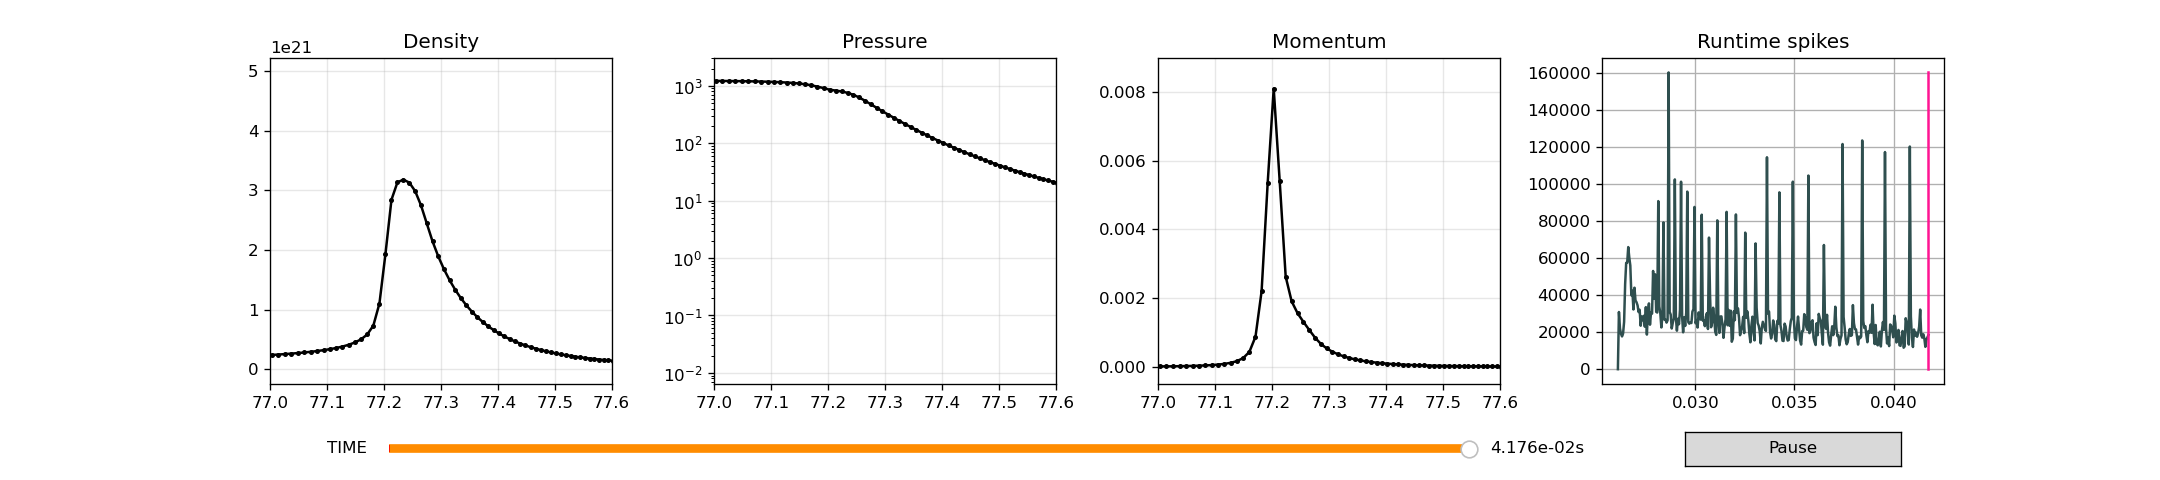

In [36]:
from matplotlib.widgets import RangeSlider, TextBox, Slider
import animatplot as amp

plt.close("all")

dpi = 120
xzoom = (77, 77.6)
wspace = 0.3
ds = cs["new_curve"].ds.isel(pos=slice(2,-2))
# params = ["NVd+", "Sd+_iz", "Sd+_rec"]
params = ["NVd+", "NVd+", "NVd+"]
# params = ["Sd+_"]
auxparam = ds["ncalls"]
# auxparam = ((ds["Nd+"]+ds["Nd"]) * ds["dv"]).sum("pos")
t = ds.coords["t"].values
num_plots = len(params)

fig = plt.figure(dpi=dpi)
fig.set_figheight(4)
fig.set_figwidth(num_plots*6)
fig.subplots_adjust(bottom = 0.2)

# Plot grid
gs0a = mpl.gridspec.GridSpec(
                                ncols=num_plots+1, nrows=1,
                                wspace = wspace,
                                width_ratios = [0.25, 0.25, 0.25, 0.25]
                                )

axes = [None] * num_plots
data = [None] * num_plots
blocks = [None] * num_plots

timeline = amp.Timeline(t, units = "s", fps = 10)


pos = ds["pos"].values

for i, param in enumerate(params):
    data[i] = ds[param].values

# Make scanning line
vline = np.repeat(np.array([[min(auxparam.values), max(auxparam.values)]]), len(t), axis = 0)



axes[0] = fig.add_subplot(gs0a[0])
blocks[0] = amp.blocks.Line(ds["pos"], ds["Ne"].values, ax = axes[0], color = "black", marker = "o", markersize = 2)
# axes[1].set_ylim(1e8 , 6e8)
axes[0].set_xlim(xzoom)
axes[0].set_title("Density")
axes[0].set_yscale("linear")

zoomds = ds.sel(pos=slice(None,None)).copy()
axes[1] = fig.add_subplot(gs0a[1])
blocks[1] = amp.blocks.Line(zoomds["pos"], zoomds["Pd+"].values, ax = axes[1], color = "black", marker = "o", markersize = 2)
# axes[1].set_ylim(1e8 , 6e8)
axes[1].set_xlim(xzoom)
axes[1].set_title("Pressure")
axes[1].set_yscale("log")


zoomds = ds.sel(pos=slice(76,None)).copy()
axes[2] = fig.add_subplot(gs0a[2])
blocks[2] = amp.blocks.Line(zoomds["pos"], zoomds[param].values, ax = axes[2], color = "black", marker = "o", markersize = 2)
axes[2].set_xlim(xzoom)
axes[2].set_title("Momentum")
axes[2].set_ylim(-0.0005, 0.009)



for i in [0,1,2]:
    axes[i].grid(alpha = 0.3)

# Aux plot and vline
axes.append(fig.add_subplot(gs0a[len(params)]))
axes[-1].plot(t, auxparam, c = "darkslategrey")
axes[-1].grid()
axes[-1].set_title("Runtime spikes")

# Line is two points, these are the X coordinates for those two points for all times
x = np.tile(t,  (2,1)).transpose()
blocks.append(amp.blocks.Line(x, vline, ax = axes[-1], t_axis=0, color = "deeppink"))

# blocks[-1] = 
    
anim = amp.Animation(blocks, timeline)
anim.controls({"text":"TIME", "color":"darkorange", "valfmt":"%1.3e"})
aux_plot_idx = num_plots
    
anim.save_gif("newcurveswalk.gif")


